# 日本のCOVID19感染者数分析(情報提供:NHK)

In [1]:
import pandas as pd

In [2]:
pref = pd.read_csv("COVID-19-jp/nhk_news_covid19_prefectures_daily_data.csv")

In [3]:
pref["日付"] = pd.to_datetime(pref["日付"] )

In [4]:
latest_date_str = pref["日付"].max().strftime("%Y/%m/%d")

In [5]:
all_jp = pref.copy().groupby(["日付"], as_index=False).sum()
del all_jp["都道府県コード"]
del all_jp["各地の感染者数_累計"]
del all_jp["各地の死者数_累計"]

In [6]:
all_jp["weekday"] = all_jp["日付"].dt.weekday
weekdays = pd.DataFrame({"曜日":["月","火","水","木","金","土","日"]})
all_jp = pd.merge(all_jp, weekdays, left_on="weekday", right_index=True, how="left")

## 移動平均

In [7]:
all_jp["感染者数移動平均7"] = all_jp["各地の感染者数_1日ごとの発表数"].rolling(7).mean()
all_jp["死者数移動平均7"] = all_jp["各地の死者数_1日ごとの発表数"].rolling(7).mean()
all_jp.tail()

,日付,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,weekday,曜日,感染者数移動平均7,死者数移動平均7
523,2021-06-22,1430,44,1,火,1423.571429,43.142857
524,2021-06-23,1775,58,2,水,1434.285714,40.000000
525,2021-06-24,1667,42,3,木,1452.000000,39.285714
526,2021-06-25,1706,31,4,金,1464.714286,36.857143
527,2021-06-26,1619,29,5,土,1480.428571,37.000000


## 増減速度

In [8]:
all_jp["感染者数移動平均7増減"] = all_jp["感染者数移動平均7"].diff()
all_jp["死者数移動平均7増減"] = all_jp["死者数移動平均7"].diff()
all_jp.tail(7)

,日付,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,weekday,曜日,感染者数移動平均7,死者数移動平均7,感染者数移動平均7増減,死者数移動平均7増減
521,2021-06-20,1302,20,6,日,1431.000000,50.000000,-11.428571,-1.714286
522,2021-06-21,864,35,0,月,1421.714286,46.428571,-9.285714,-3.571429
523,2021-06-22,1430,44,1,火,1423.571429,43.142857,1.857143,-3.285714
524,2021-06-23,1775,58,2,水,1434.285714,40.000000,10.714286,-3.142857
525,2021-06-24,1667,42,3,木,1452.000000,39.285714,17.714286,-0.714286
526,2021-06-25,1706,31,4,金,1464.714286,36.857143,12.714286,-2.428571
527,2021-06-26,1619,29,5,土,1480.428571,37.000000,15.714286,0.142857


## 都道府県別

In [9]:
pref["感染者数移動平均7"] = pref["各地の感染者数_1日ごとの発表数"].rolling(7).mean()

### 人口あたり

In [10]:
pop = pd.read_excel("COVID-19-jp/2001stjin.xls",header=3)[["Unnamed: 1","計"]]
pop.rename(columns={"Unnamed: 1":"都道府県名"},inplace=True)
pop.rename(columns={"計":"人口"},inplace=True)
pop = pop.loc[pop["都道府県名"]!="合計"].reset_index(drop=True)
pref = pd.merge(pref, pop, on="都道府県名", how="left")

In [11]:
pref["10万人あたり感染者数"] = pref["各地の感染者数_1日ごとの発表数"]/(pref["人口"]/100000)
pref["10万人あたり感染者数移動平均7"] = pref["10万人あたり感染者数"].rolling(7).mean()
pref["10万人あたり感染者数1週間合計"] = pref["10万人あたり感染者数"].rolling(7).sum()

### 感染者数前日比

In [12]:
import numpy as np
pref["感染者数前日比"] = pref["各地の感染者数_1日ごとの発表数"].pct_change()
pref["感染者数前日差"] = pref["各地の感染者数_1日ごとの発表数"].diff()
# 一番古い日付だけNANを設定
pref.loc[pref["日付"]==pref["日付"].min(),"感染者数前日比"] = np.nan
pref["感染者数前日比移動平均7"] = pref["感染者数前日比"].rolling(7).mean()
pref["10万人あたり感染者数移動平均7前日差"] = pref["10万人あたり感染者数移動平均7"].diff()
pref["感染者数移動平均7前日差"] = pref["感染者数移動平均7"].diff()

## 曜日別陽性者集計

In [13]:
all_jp_week_mean = all_jp.groupby(["weekday"],as_index=False).mean()[["各地の感染者数_1日ごとの発表数","各地の死者数_1日ごとの発表数"]].sort_index()
all_jp_week_mean = pd.merge(all_jp_week_mean, weekdays, left_index=True, right_index=True, how="left")
all_jp_week_mean

,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,曜日
0,1021.360000,25.480000,月
1,1396.466667,33.520000,火
2,1629.480000,32.106667,水
3,1697.934211,29.342105,木
4,1646.710526,30.776316,金
5,1692.447368,24.855263,土
6,1395.800000,18.253333,日


In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook
#%matplotlib inline

<IPython.core.display.Javascript object>


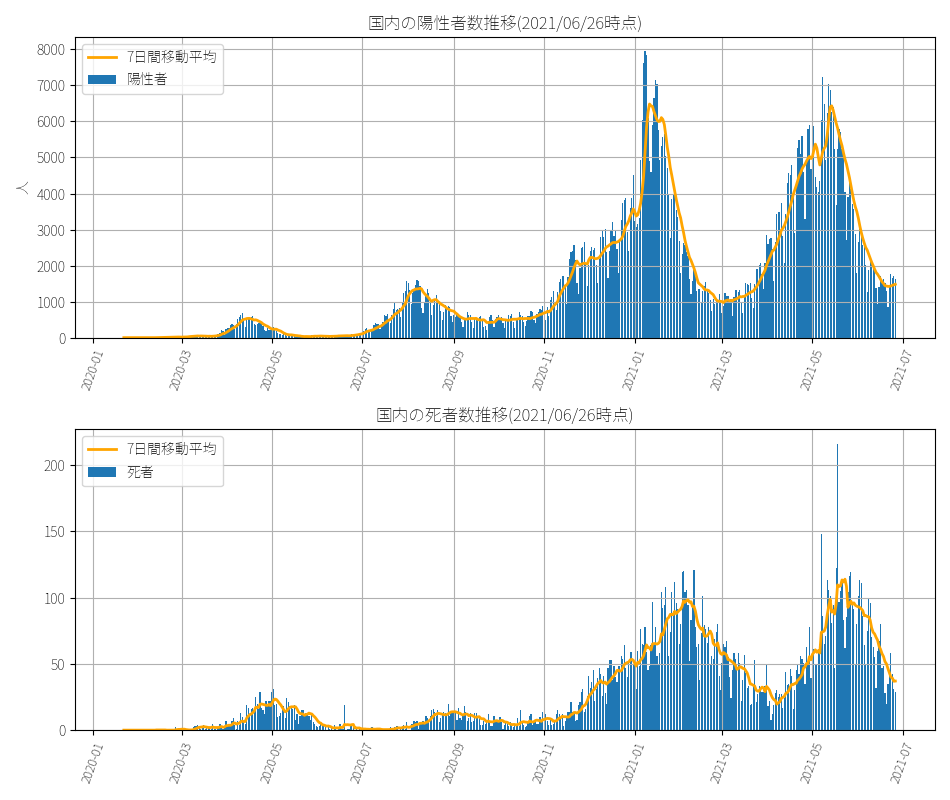

In [15]:
fig=plt.figure(figsize=(9.5,8))
plt.subplot(2,1,1) # (rows, columns, panel number)
plt.title("国内の陽性者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp["日付"],all_jp["各地の感染者数_1日ごとの発表数"],label="陽性者")
plt.plot_date(all_jp["日付"],all_jp["感染者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x",rotation=70, labelsize=9)
plt.ylabel("人")
plt.grid()
plt.legend()

plt.subplot(2,1,2) # (rows, columns, panel number)
plt.title("国内の死者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp["日付"],all_jp["各地の死者数_1日ごとの発表数"],label="死者")
plt.plot_date(all_jp["日付"],all_jp["死者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x",rotation=70, labelsize=9)
plt.grid()
plt.legend()

fig.tight_layout()


<IPython.core.display.Javascript object>


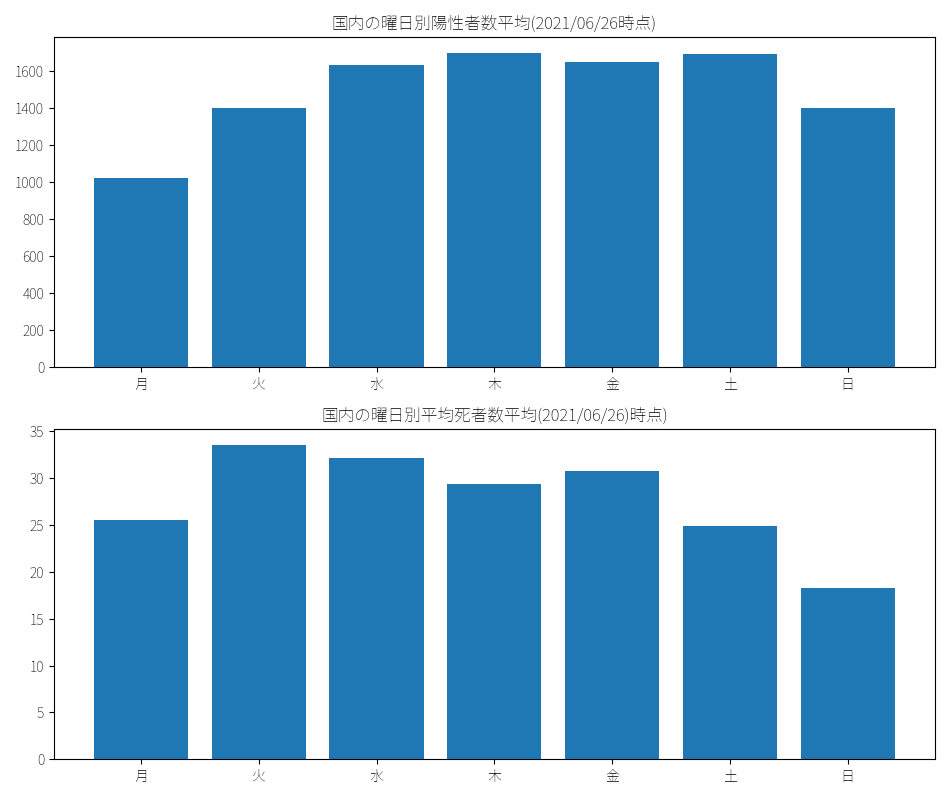

<BarContainer object of 7 artists>

In [16]:
fig=plt.figure(figsize=(9.5,8),tight_layout=True)
plt.subplot(2,1,1) # (rows, columns, panel number)
#fig, ax = plt.subplots(2,1,figsize=(9,8),tight_layout=True)
#wp_ax = ax[0]
plt.title("国内の曜日別陽性者数平均({}時点)".format(latest_date_str))
plt.bar(all_jp_week_mean["曜日"],all_jp_week_mean["各地の感染者数_1日ごとの発表数"])
#wd_ax = ax[1]
plt.subplot(2,1,2) # (rows, columns, panel number)
plt.title("国内の曜日別平均死者数平均({})時点)".format(latest_date_str))
plt.bar(all_jp_week_mean["曜日"],all_jp_week_mean["各地の死者数_1日ごとの発表数"])

## 直近の推移

In [17]:
recent_date = pd.to_datetime("2021-04-01")
all_jp_recent = all_jp.loc[all_jp["日付"]>=recent_date]
all_jp_recent.tail()

,日付,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,weekday,曜日,感染者数移動平均7,死者数移動平均7,感染者数移動平均7増減,死者数移動平均7増減
523,2021-06-22,1430,44,1,火,1423.571429,43.142857,1.857143,-3.285714
524,2021-06-23,1775,58,2,水,1434.285714,40.000000,10.714286,-3.142857
525,2021-06-24,1667,42,3,木,1452.000000,39.285714,17.714286,-0.714286
526,2021-06-25,1706,31,4,金,1464.714286,36.857143,12.714286,-2.428571
527,2021-06-26,1619,29,5,土,1480.428571,37.000000,15.714286,0.142857


<IPython.core.display.Javascript object>


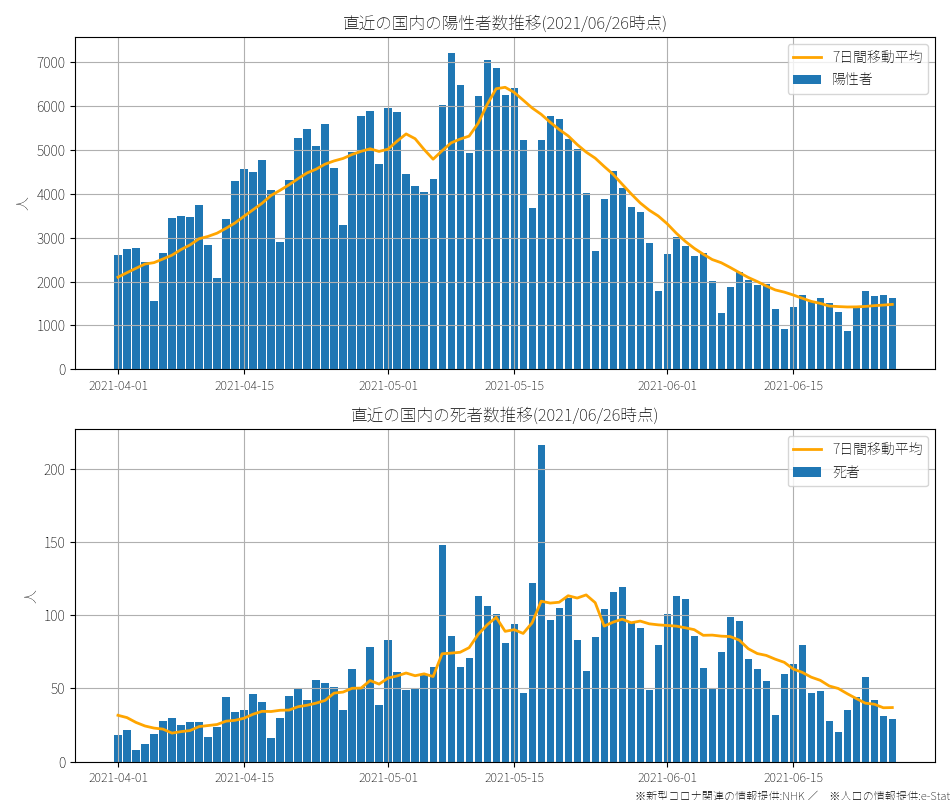

In [18]:
fig=plt.figure(figsize=(9.5,8))
plt.subplot(2,1,1) # (rows, columns, panel number)
plt.title("直近の国内の陽性者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp_recent["日付"],all_jp_recent["各地の感染者数_1日ごとの発表数"],label="陽性者")
plt.plot_date(all_jp_recent["日付"],all_jp_recent["感染者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
#plt.plot_date(all_jp_latest["日付"],all_jp_latest["直近１週間の新規感染者数合計"]/10,label="直近１週間の合計(10人)", fmt="-",lw=2.0, color="m")
plt.tick_params(axis="x",labelsize=9)
plt.ylabel("人")
plt.grid()
plt.legend()

plt.subplot(2,1,2) # (rows, columns, panel number)
plt.title("直近の国内の死者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp_recent["日付"],all_jp_recent["各地の死者数_1日ごとの発表数"],label="死者")
plt.plot_date(all_jp_recent["日付"],all_jp_recent["死者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x", labelsize=9)
plt.ylabel("人")
plt.grid()
plt.legend()

fig.text(1,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=8,ha="right")

fig.tight_layout()

In [19]:
fig.savefig("out/covid-nhk-domestic-daily.png")

### 都道府県別

In [20]:
prefs = {
    "沖縄県": ("-",1.1,""),
    "東京都": ("--",1.0,""),
    "大阪府": ("--",1.0,"2021-05-01"),
    "京都府": ("--",1.0,""),
    "兵庫県": ("--",1.0,"2021-04-28"),
    "愛知県": ("--",1.0,"2021-05-25"),
    "福岡県": ("--",1.0,"2021-04-25"),
    "北海道": ("--",1.0,"2021-05-25"),
#    "岡山県": ("--",1.0,""),
#    "広島県": ("--",1.0,"2021-04-15"),
    "埼玉県": ("--",1.0,""),
    "千葉県": ("--",1.0,""),
    "神奈川県": ("--",1.0,""),
#    "岐阜県": ("--",1.0,"2021-05-16"),
#    "三重県": ("--",1.0,"2021-05-27"),
#    "石川県": ("--",1.0,""),
#    "群馬県": ("--",1.0,""),
#    "熊本県": ("--",1.0,""),
#    "山梨県": (":",1.0,""),
#    "大分県": (":",1.5,""),
#    "佐賀県": (":",1.5,""),
#    "奈良県": (":",1.5,""),
#    "山口県": (":",1.5,""),
#    "滋賀県": (":",1.5,""),
#    "高知県": (":",1.5,""),
#    "青森県": (":",1.5,""),
#    "富山県": (":",1.5,""),
}

In [21]:
pref_recent = pref.loc[pref["日付"]>=recent_date]

<IPython.core.display.Javascript object>


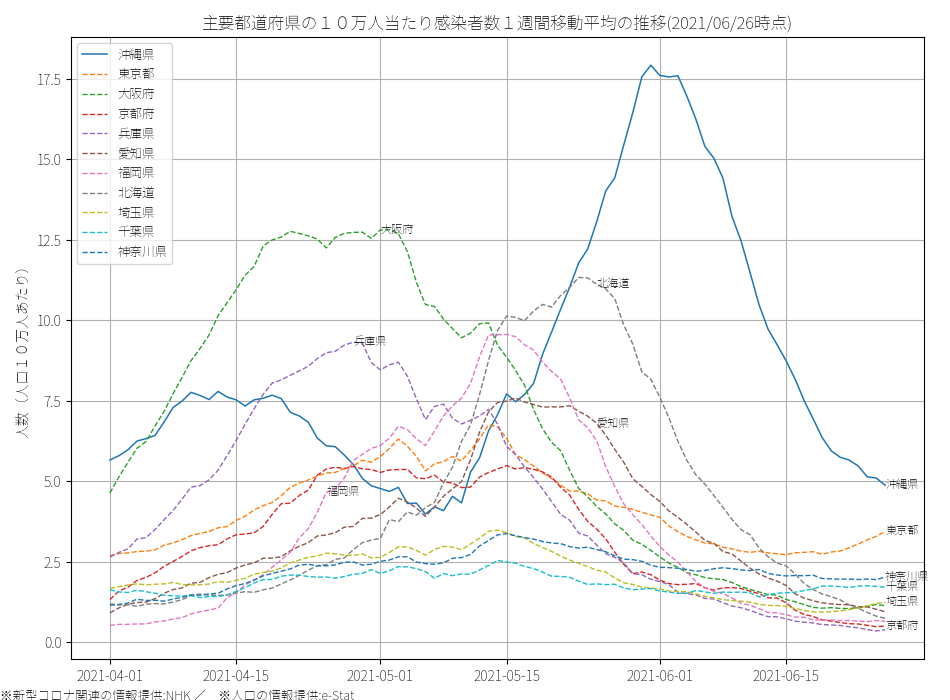

In [22]:
fig = plt.figure(figsize=(9.5,7))
plt.title("主要都道府県の１０万人当たり感染者数１週間移動平均の推移({}時点)".format(latest_date_str))
dates = pref_recent["日付"].unique()
for p in prefs:
    values = pref_recent.loc[pref_recent["都道府県名"]==p]["10万人あたり感染者数移動平均7"]
    plt.plot_date(dates,values,label=p, fmt=prefs[p][0], lw=prefs[p][1])
    if prefs[p][2] == "":
        text_date = dates.max()
    else:
        text_date = pd.to_datetime(prefs[p][2])
    text_y = pref_recent.loc[(pref_recent["都道府県名"]==p) & (pref_recent["日付"]==text_date)]["10万人あたり感染者数移動平均7"]
    plt.text(text_date,text_y,p,fontsize=8,va="center")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("人数（人口１０万人あたり）")
fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)

plt.tight_layout()

<IPython.core.display.Javascript object>


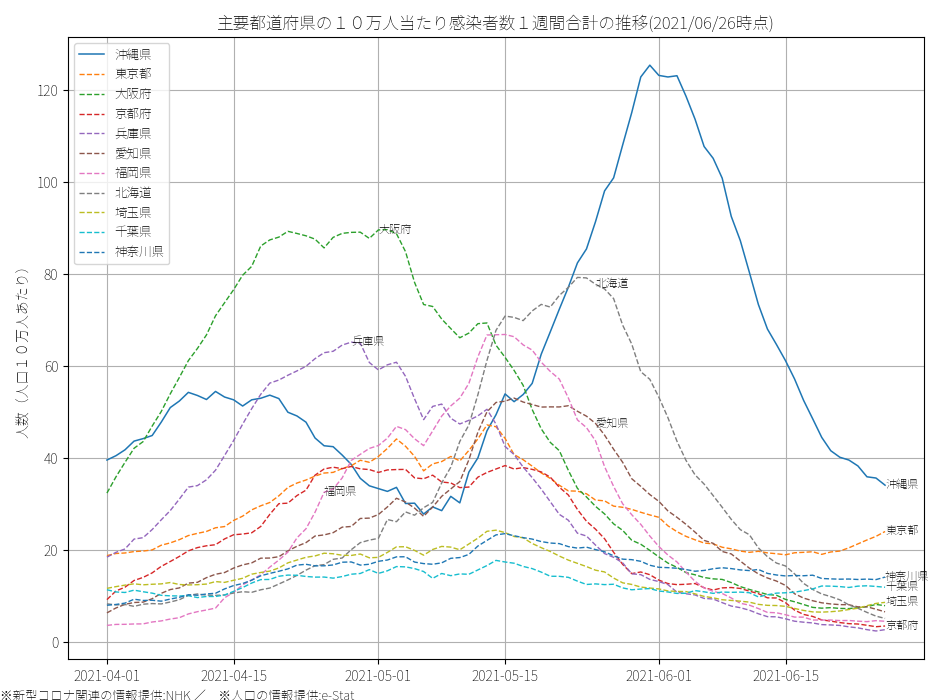

In [23]:
fig = plt.figure(figsize=(9.5,7))
plt.title("主要都道府県の１０万人当たり感染者数１週間合計の推移({}時点)".format(latest_date_str))
dates = pref_recent["日付"].unique()
for p in prefs:
    values = pref_recent.loc[pref_recent["都道府県名"]==p]["10万人あたり感染者数1週間合計"]
    plt.plot_date(dates,values,label=p, fmt=prefs[p][0], lw=prefs[p][1])
    if prefs[p][2] == "":
        text_date = dates.max()
    else:
        text_date = pd.to_datetime(prefs[p][2])
    text_y = pref_recent.loc[(pref_recent["都道府県名"]==p) & (pref_recent["日付"]==text_date)]["10万人あたり感染者数1週間合計"]
    plt.text(text_date,text_y,p,fontsize=8,va="center")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("人数（人口１０万人あたり）")
fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)

plt.tight_layout()

In [24]:
fig.savefig("out/covid-nhk-domestic-major-pref-daily-recent.png")

## 感染速度

<IPython.core.display.Javascript object>


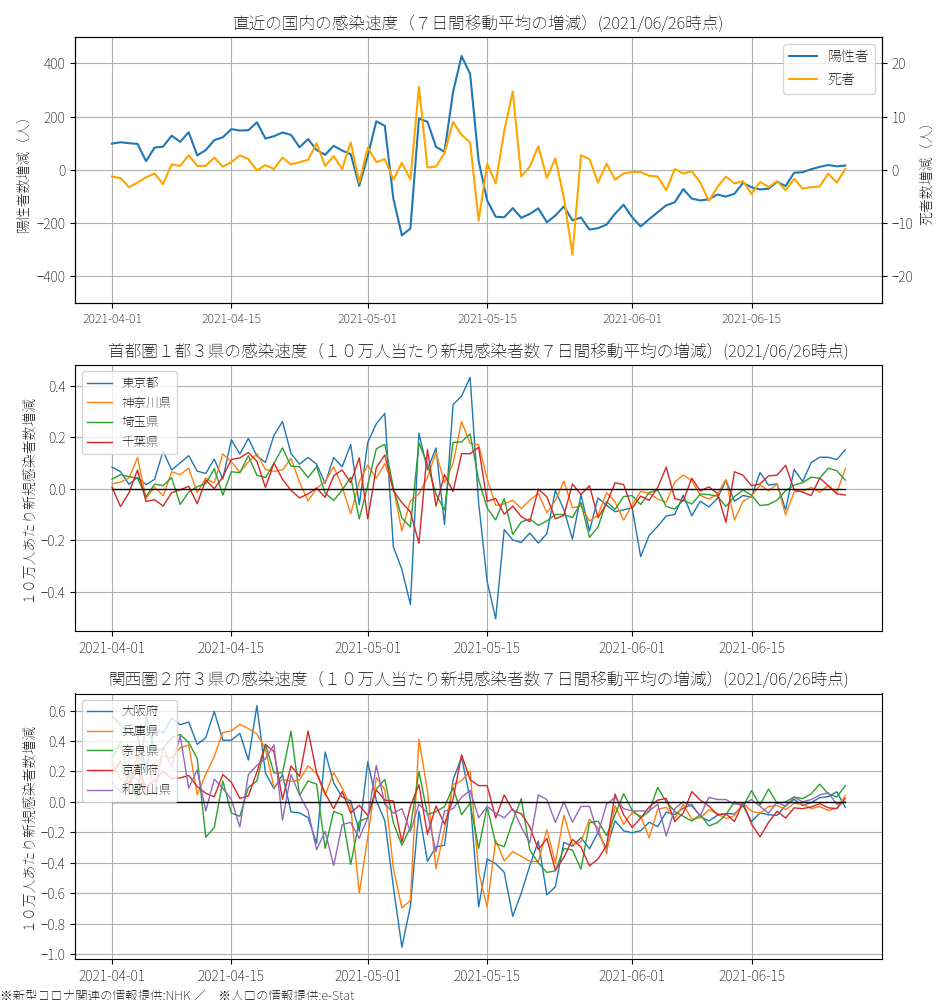

Text(0, 0, '※新型コロナ関連の情報提供:NHK ／\u3000※人口の情報提供:e-Stat')

In [25]:
fig = plt.figure(figsize=(9.5,10),tight_layout=True)
ax1 = plt.subplot(3,1,1) # (rows, columns, panel number)
plt.title("直近の国内の感染速度（７日間移動平均の増減）({}時点)".format(latest_date_str))
plt.plot_date(all_jp_recent["日付"],all_jp_recent["感染者数移動平均7増減"],label="陽性者",fmt="-")
plt.tick_params(axis="x",labelsize=9)
plt.ylabel("陽性者数増減（人）")
plt.grid()
plt.ylim(-500,500)
ax2 = plt.twinx()
ax2.plot_date(all_jp_recent["日付"],all_jp_recent["死者数移動平均7増減"],label="死者",fmt="-", color="orange")
plt.ylabel("死者数増減（人）")
plt.ylim(-25,25)
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2,l1+l2)

chart_data = pref_recent
dates = chart_data["日付"].unique()

ax1 = plt.subplot(3,1,2) # (rows, columns, panel number)
plt.title("首都圏１都３県の感染速度（１０万人当たり新規感染者数７日間移動平均の増減）({}時点)".format(latest_date_str))
target_p = ["東京都","神奈川県","埼玉県","千葉県"]
#stack_values = []
for p in target_p:
#    stack_values.append(chart_data.loc[chart_data["都道府県名"]==p]["10万人あたり感染者数移動平均7前日差"])
    values = chart_data.loc[chart_data["都道府県名"]==p]["10万人あたり感染者数移動平均7前日差"]
#    plt.fill_between(dates,values)
    plt.plot_date(dates,values,label=p, fmt="-", lw=1)
#plt.stackplot(dates, stack_values, labels=target_p)
plt.plot([dates.min(),dates.max()],[0,0],lw=1,color="black")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("１０万人あたり新規感染者数増減")

ax1 = plt.subplot(3,1,3) # (rows, columns, panel number)
plt.title("関西圏２府３県の感染速度（１０万人当たり新規感染者数７日間移動平均の増減）({}時点)".format(latest_date_str))
target_p = ["大阪府","兵庫県","奈良県","京都府","和歌山県"]
for p in target_p:
    values = chart_data.loc[chart_data["都道府県名"]==p]["10万人あたり感染者数移動平均7前日差"]
    plt.plot_date(dates,values,label=p, fmt="-", lw=1)
plt.plot([dates.min(),dates.max()],[0,0],lw=1,color="black")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("１０万人あたり新規感染者数増減")


fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)

In [26]:
fig.savefig("out/covid-nhk-domestic-velocity-daily.png")